# Location suggestions generator for restaurant opening
# Exploratory Data Analysis on Just eat data

The aim of this EDA is to understand the data I currently have on just eat, confirm how exhaustive and accurate they are.


In [1]:
import requests
from bs4 import BeautifulSoup
import urllib2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sqlalchemy.engine import create_engine

In [2]:
#connection to the postgre database
engine=create_engine('postgresql://localhost:5432/capstone')
conn=engine.connect()

In [3]:
#reading the table gather just-eat information, 
#please refers to the just-eat ipython notebook in the same folder for the web scraping
df=pd.read_sql("just_eat_2",con=conn)

In [4]:
#deleting false index column

del df["index"]

In [5]:
# removing duplicate

print "Shape before removing duplicate",df.shape
df=df.drop_duplicates()
print "Shape after removing duplicate", df.shape
print "Number of restaurants registered on just-eat.co.uk :",len(df)
print "I am assuming that it is close from an exhaustive list of restaurant proposing take-away in London"

Shape before removing duplicate (55399, 7)
Shape after removing duplicate (7423, 7)
Number of restaurants registered on just-eat.co.uk : 7423
I am assuming that it is close from an exhaustive list of restaurant proposing take-away in London


In [6]:
df.reset_index(drop=True, inplace=True)
df.head()

,Address,Cuisine,Minimum spend,Name,Number of votes,Ranking,Url
0,"430 Downham Way, Bromley, BR1 5HR","Kebab, Pizza, Halal",12,Milano Kebab & Pizza,1422,5,https://www.just-eat.co.uk/restaurants-milanok...
1,"89 Beckenham Lane, Bromley, BR2 0DN","Kebab, Pizza",10,Shortlands Kebab,247,5,https://www.just-eat.co.uk/restaurants-shortla...
2,"284 Sangley Road, Catford, SE6 2JT","Indian, Curry, Halal",12,Curry Cottage,1084,5,https://www.just-eat.co.uk/restaurants-curryco...
3,"6a Randlesdown Road, Bellingham, SE6 3BT","Chinese, Oriental",£0,China - Local,334,5,https://www.just-eat.co.uk/restaurants-china--...
4,"12 Addington Road, West Wickham, Kent, BR4 9BS",Indian,12,Zeera Spice,138,5,https://www.just-eat.co.uk/restaurants-zeera-s...


Definition of each column:
    - Address: Detailed address of the restaurant
    - Cuisine: Type of cuisine or topic link to the food proposed by the restaurant
    - Minimum Spend: the minimum required for an order
    - Name: Name of the restaurant
    - Number of votes: Number of vote that the restaurant received since it has been added to just eat
    - Ranking: restaurant's mark
    - URL: Link to the restaurant page
    
From this dataset, we can already raised some questions:
    - How exhaustive is the list of restaurant?
    - Does Minimum spend link to average spend?
    - Does the ranking and number of votes reflect the quality/ well functioning of a restaurant?
        (i.e: how many noise (fake reviews) does it contains, good ranking means healthy finance?)

In [7]:
# Let's look at some data and clean whatever is necesary 
#NaN value
df.isnull().sum()

Address               0
Cuisine               0
Minimum spend      1175
Name                  0
Number of votes       0
Ranking               0
Url                   0
dtype: int64

In [8]:
# type of each columns
df.dtypes

Address            object
Cuisine            object
Minimum spend      object
Name               object
Number of votes    object
Ranking            object
Url                object
dtype: object

In [9]:
# type modification ranking
df["Ranking"]=df["Ranking"].astype("float")

In [10]:
# the code seems not to have taken the number of votes for New restaurant.

New=df.loc[df["Number of votes"].str.contains("New*"),:]
New.head()

,Address,Cuisine,Minimum spend,Name,Number of votes,Ranking,Url
6,"267 Brown Hill Road, London, SE6 1AE","Pizza, Italian, Halal",10,Tops Pizza,New\n\n(22,5.0,https://www.just-eat.co.uk/restaurants-topspiz...
27,"350 Baring Road, London, SE12 0DU","Indian, Curry",12,The Grove,New\n\n(17,5.0,https://www.just-eat.co.uk/restaurants-the-gro...
87,"4 Well Hall Road, London, SE9 6SF","Sushi, Japanese, Halal",15,Umi Sushi Bar,New\n\n(4,5.0,https://www.just-eat.co.uk/restaurants-umi-sus...
119,"182A High Street, Orpington, BR6 0JW","Indian, Curry, Halal",12,Afsana Spice,New\n\n(41,5.0,https://www.just-eat.co.uk/restaurants-afsana-...
193,"72 Southbridge Street, South Croyden, CR0 1AE","Chicken, Pizza, Halal",10,Morley's,New\n\n(4,5.0,https://www.just-eat.co.uk/restaurants-morleys...


In [11]:
# Retrieving the 'New\n\n(' from our main dataframe df + save the information if a restaurant is new or not.
df["New_on_4_12_2016"]=np.zeros((len(df),1))
df["New_on_4_12_2016"].loc[df["Number of votes"].str.contains("New*")]=1.0
df["Number of votes"].loc[df["Number of votes"].str.contains("New*")]=\
df["Number of votes"].loc[df["Number of votes"].str.contains("New*")].apply(lambda x: x[len("New\n\n("):])
df["Number of votes"]=df["Number of votes"].astype("int")
df.head()

/Users/dorian/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Address,Cuisine,Minimum spend,Name,Number of votes,Ranking,Url,New_on_4_12_2016
0,"430 Downham Way, Bromley, BR1 5HR","Kebab, Pizza, Halal",12,Milano Kebab & Pizza,1422,5.0,https://www.just-eat.co.uk/restaurants-milanok...,0.0
1,"89 Beckenham Lane, Bromley, BR2 0DN","Kebab, Pizza",10,Shortlands Kebab,247,5.0,https://www.just-eat.co.uk/restaurants-shortla...,0.0
2,"284 Sangley Road, Catford, SE6 2JT","Indian, Curry, Halal",12,Curry Cottage,1084,5.0,https://www.just-eat.co.uk/restaurants-curryco...,0.0
3,"6a Randlesdown Road, Bellingham, SE6 3BT","Chinese, Oriental",£0,China - Local,334,5.0,https://www.just-eat.co.uk/restaurants-china--...,0.0
4,"12 Addington Road, West Wickham, Kent, BR4 9BS",Indian,12,Zeera Spice,138,5.0,https://www.just-eat.co.uk/restaurants-zeera-s...,0.0


In [12]:

df.dtypes

Address              object
Cuisine              object
Minimum spend        object
Name                 object
Number of votes       int64
Ranking             float64
Url                  object
New_on_4_12_2016    float64
dtype: object

In [13]:
# Let's deal with missing value of Minimum Spend later on, when we will understand better the data.
# how many cuisine display per restaurant?
cuisine={}
max_cuisine=[]
for cuis in df["Cuisine"]:
    listy=cuis.split(",")
    max_cuisine.append(len(listy))
    for item in listy:
        if item not in cuisine.keys():
            cuisine[item]=1
        else:
            cuisine[item]=cuisine[item]+1

print "Number of cuisine types/qualifications per restaurant (Max, Min, Average):\n", (max(max_cuisine),min(max_cuisine),round(np.mean(max_cuisine),0))
print "Total number of cuisine types/qualifications:\n", len(cuisine.keys())
print "Some cuisine types:\n",cuisine.keys()[:10]

Number of cuisine types/qualifications per restaurant (Max, Min, Average):
(3, 1, 2.0)
Total number of cuisine types/qualifications:
199
Some cuisine types:
[u' Asian', u'Gourmet', u'Argentinian', u'Continental', u'Sandwiches', u' Gluten Free', u'European', u' Trinidadian', u' Subways', u'Dim Sum']


In [14]:
# let's create 3 columns cuisine 1, cuisine 2, cuisine 3 on df
# This will enable us to see more clearly the types and probably group restaurant per main type of cuisine

def split_cuisine(row,position):
    listy=row.split(",")
    result=""
    if position <= len(listy)-1:
        result=listy[position]
    else:
        result=""
    return result

df["Cuisine_1"]=df["Cuisine"].apply(lambda x: split_cuisine(x,0))
df["Cuisine_2"]=df["Cuisine"].apply(lambda x: split_cuisine(x,1))
df["Cuisine_3"]=df["Cuisine"].apply(lambda x: split_cuisine(x,2))

df.head()

,Address,Cuisine,Minimum spend,Name,Number of votes,Ranking,Url,New_on_4_12_2016,Cuisine_1,Cuisine_2,Cuisine_3
0,"430 Downham Way, Bromley, BR1 5HR","Kebab, Pizza, Halal",12,Milano Kebab & Pizza,1422,5.0,https://www.just-eat.co.uk/restaurants-milanok...,0.0,Kebab,Pizza,Halal
1,"89 Beckenham Lane, Bromley, BR2 0DN","Kebab, Pizza",10,Shortlands Kebab,247,5.0,https://www.just-eat.co.uk/restaurants-shortla...,0.0,Kebab,Pizza,
2,"284 Sangley Road, Catford, SE6 2JT","Indian, Curry, Halal",12,Curry Cottage,1084,5.0,https://www.just-eat.co.uk/restaurants-curryco...,0.0,Indian,Curry,Halal
3,"6a Randlesdown Road, Bellingham, SE6 3BT","Chinese, Oriental",£0,China - Local,334,5.0,https://www.just-eat.co.uk/restaurants-china--...,0.0,Chinese,Oriental,
4,"12 Addington Road, West Wickham, Kent, BR4 9BS",Indian,12,Zeera Spice,138,5.0,https://www.just-eat.co.uk/restaurants-zeera-s...,0.0,Indian,,


In [15]:
# how is the hierarchy?
pivot1=pd.pivot_table(df,index=["Cuisine_1","Cuisine_2","Cuisine_3"],values=["Ranking"],aggfunc=np.count_nonzero)
pivot1[:20]

Ranking
Cuisine_1      Cuisine_2       Cuisine_3         
*London Loves*                                0.0
Afghan          Halal                         1.0
                Indian          Halal         3.0
                Iranian         Halal         1.0
                Kebab           Halal         3.0
                Middle Eastern                4.0
                                Halal        10.0
                Pakistani       Halal         3.0
                Persian         Halal         5.0
African                                       6.0
                Caribbean                     7.0
                                Halal        10.0
                Nigerian                     10.0
                                Halal        10.0
American                                      4.0
                *London Loves*                6.0
                Breakfast       Halal         1.0
                British                       1.0
                Burgers                       6.0
                                Halal         7.0

In [16]:
cuisine_1=df["Cuisine_1"].unique()
print "Main Cuisine number",len(cuisine_1)
cuisine_2=df["Cuisine_2"].unique()
print "Second Cuisine number",len(cuisine_2)
cuisine_3=df["Cuisine_3"].unique()
print "Third Cuisine number",len(cuisine_3)
print cuisine_3

Main Cuisine number 101
Second Cuisine number 99
Third Cuisine number 2
[u' Halal' '']


We can not take into consideration cuisine_3

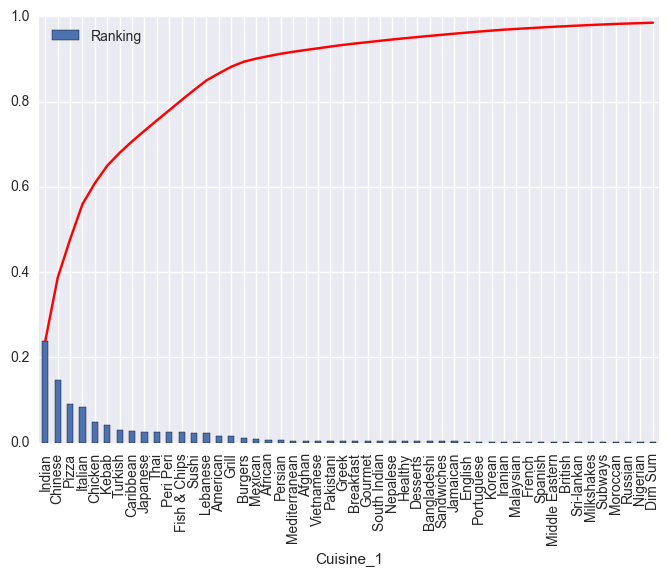

In [17]:
# how is the distribution of "main" cuisine?
pivot3=pd.pivot_table(df,index=["Cuisine_1"],values=["Ranking"],aggfunc=np.count_nonzero).sort_values(by="Ranking",ascending=False)
pivot4=pivot3/sum(pivot3.values)
pivot4[:50].plot(kind="bar")
plt.plot(np.cumsum(pivot4[:50].values),c="r")
plt.show()

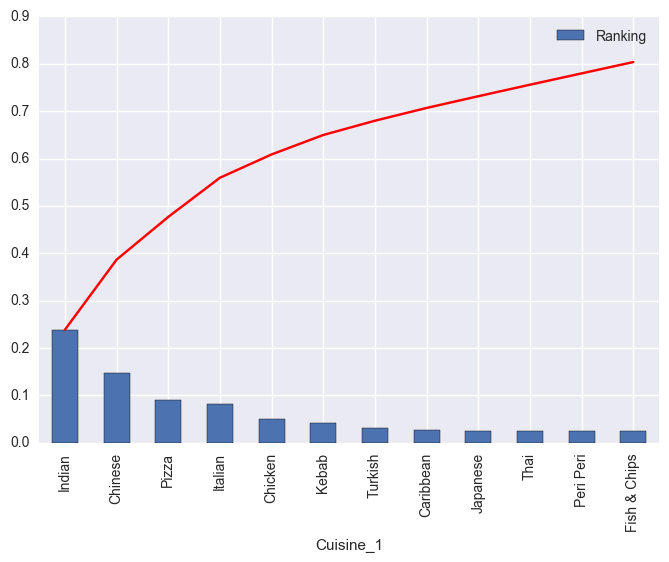

In [18]:
# Looking at cuisine type representing 80% of the restaurant.
pivot4[:12].plot(kind="bar")
plt.plot(np.cumsum(pivot4[:12].values),c="r")
plt.show()

As we can see,12 types of restaurant represents 80% of the cuisine on just-eat.
We'll try to join other cuisine in group such as it reflects the cuisine of their region (Middle east, Asian, East Europe,..)

In [19]:
#Let's regroup restaurant in categorie of cuisine
dic_cuisine={"Meat": ["Rotisserie","Steak","Argentinian","BBQ","Brazilian food","Grill","European","Kosher","South American"],\
     "Chinese":["Chinese","Cantonese","Dim Sum"],\
     "Japanese":["Japanese","Sushi"],\
     "Thai":["Thai"],\
     "Asian":["Malaysian","Vietnamese","Korean","Indonesian","Asian","Filipino","Noodles","Indo-Chinese Fusion","Fusion"],\
     "Turkish":["Turkish"],\
     "Pizza":["Pizza"],\
     "Kebab":["Kebab"],\
     "Mediterranean":["Mediterranean","Portuguese","Spanish","Greek","Peruvian","Seafood","Tapas"],\
     "African":["West African","African",'Nigerian',"Moroccan","Egyptian","Ethiopian","Ghanaian","Mauritian"],\
     "Italian":["Italian","Pasta","Authentic Pizza"],\
     "French":["French","Crepes"],\
     "Middle Eastern":["Middle Eastern","Syrian","Lebanese","Iraqi","Persian","Pakistani","Iranian","Afghan","Azerbaijan","Arabic"],\
     "Carribean":['Caribbean',"Jamaican"],\
     "Indian": ["Indian","Nepalese","Bangladeshi","Sri-lankan","South Indian","Curry","Punjabi","Street Food"],\
     "British":["Fish & Chips","British","English","Continental"],\
     "Eastern Europe":["Polish","Russian","Hungarian","Georgian","Eastern European"],\
     "Healthy":["Healthy","Vegan","Vegetarian","Gluten Free"],\
     "cafe":["Milkshakes","Breakfast","Sandwiches","Desserts","Cafe","Panini\'s","Cakes","Bubble Tea","Ice Cream","Smoothies","Drinks","Salads"],\
     "Northern American": ["Chicken", "Peri Peri","American","Burgers","Mexican","Gourmet","Bagels","Subways"]}

In [20]:
#change "Café with Cafe word for coding ease
df["Cuisine_1"].loc[df["Cuisine_1"].str.contains("Caf")]="Cafe"

In [21]:
# this function will enable organization of cuisine types in main groups
def group_resto(row):
    position=-1
    word=""
    for i in range(len(dic_cuisine.values())):
        if row in dic_cuisine.values()[i]:
            position=i
    if position ==-1:
        word=np.nan
    else:
        word=dic_cuisine.keys()[position]
    
    return word
        
        
df["group_cuisine"]=df["Cuisine_1"].apply(group_resto)

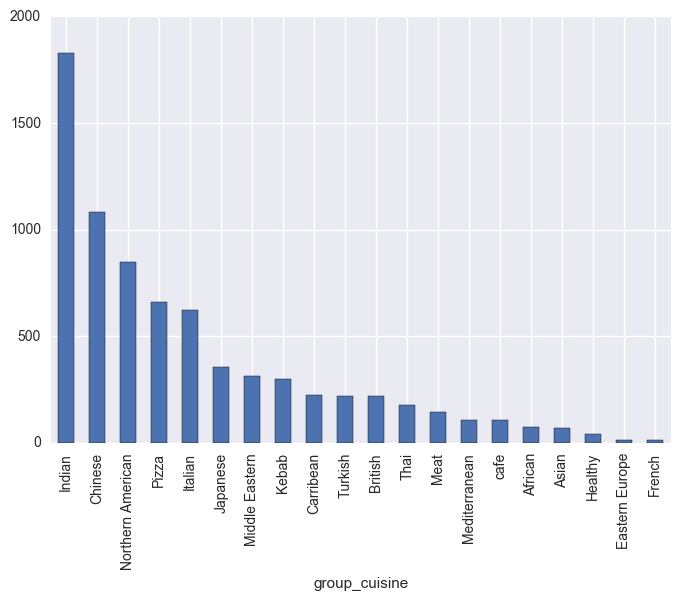

In [22]:
#let's have a look to the cuisine:
df=df.loc[df["group_cuisine"].isnull()==False,:]
df.reset_index(drop=True, inplace=True)
cuisine_qty=df.groupby(["group_cuisine"]).size().sort_values(ascending=False)
cuisine_qty.plot(kind="bar")
plt.show()

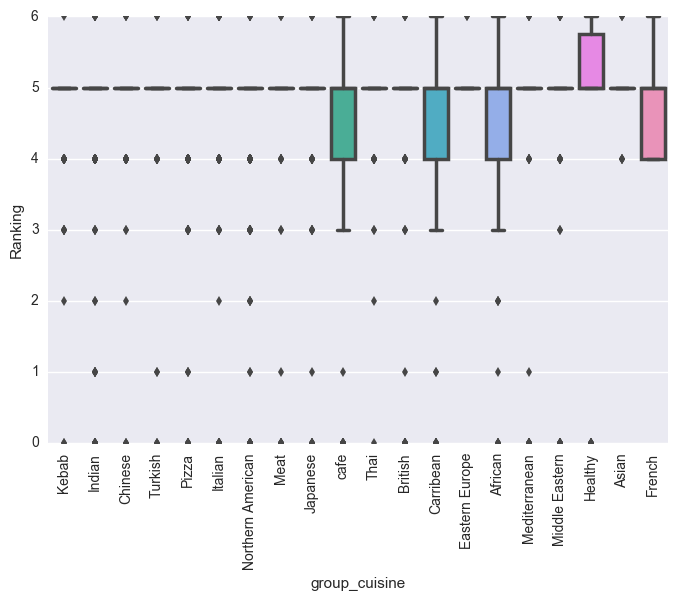

In [23]:
# look at the rating per type of food
cuisine_qty=df.groupby(["group_cuisine"])["Ranking"].size().sort_values(ascending=False)
sns.boxplot(x="group_cuisine", y="Ranking", data=df, linewidth=2.5)
plt.xticks(rotation=90)
plt.show()

As we can see there, it will be difficult to classify a restaurant on top of its ranking as it seems almost all restaurants are rank as 5 stars over 6 per users. We can wonder how trustworthy the grades are...

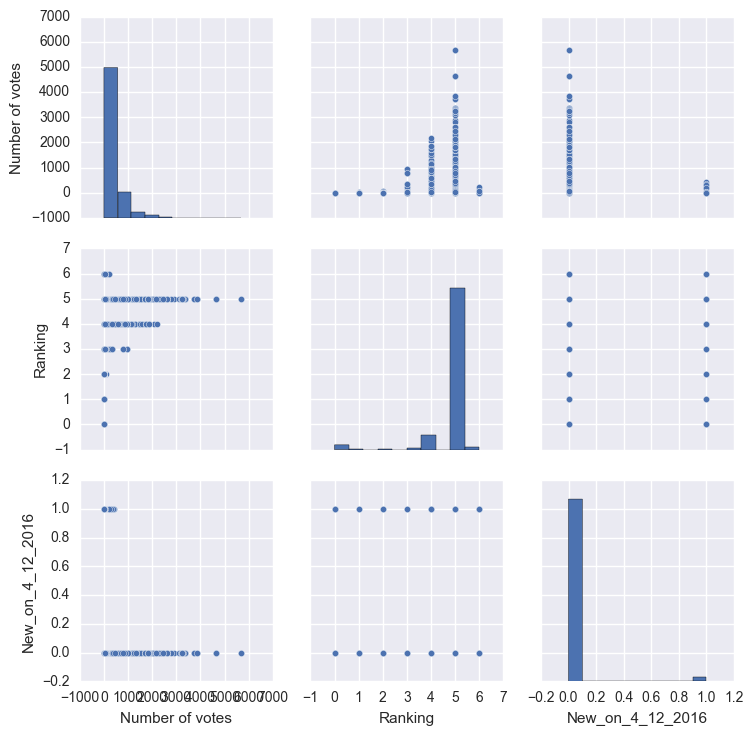

In [24]:
# let's see at some correlation

sns.pairplot(df,dropna=False)
plt.show()

In [25]:
# looking at the dataframe with minimum spend value

#first it's seems that the signe "£" is present in some rows of "Minimun spend" column.
# let's clean that
df["Minimum spend"].loc[df["Minimum spend"].isnull()==False]=df["Minimum spend"].loc[df["Minimum spend"].isnull()==False].str.encode(encoding='UTF-8',errors='strict')
df["Minimum spend"].loc[df["Minimum spend"].isnull()==False]=df["Minimum spend"].loc[df["Minimum spend"].isnull()==False].str.strip("£")



/Users/dorian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


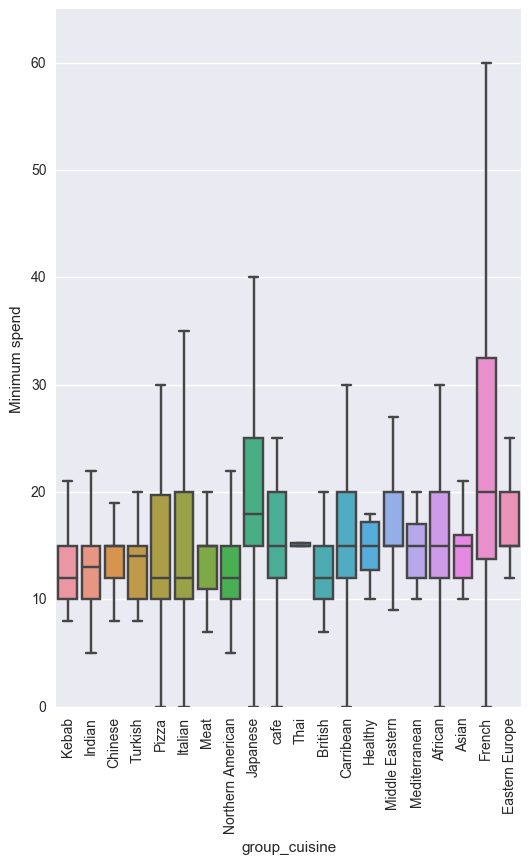

Mean Minimum spent: £ 18


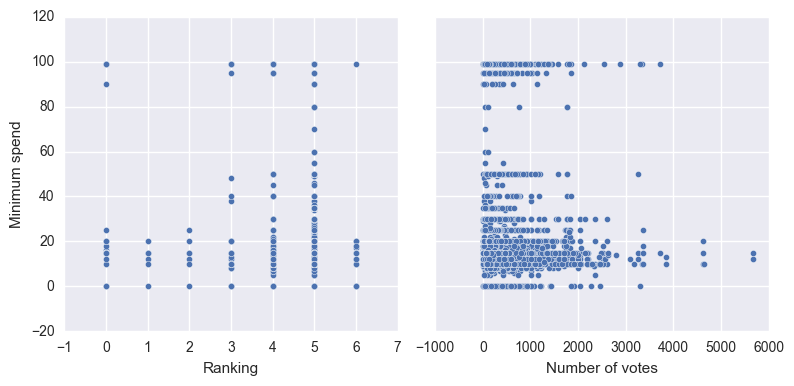

In [26]:

df_with_M=df.loc[df["Minimum spend"].isnull()==False,:]
df_with_M["Minimum spend"]=df_with_M["Minimum spend"].astype("int")

plt.figure(figsize=(6,9))
sns.boxplot(data=df_with_M,y="Minimum spend",fliersize=-1,x="group_cuisine")
plt.ylim((0,65))
plt.xticks(rotation=90)

plt.show()

print "Mean Minimum spent: £" , int(np.mean(df_with_M["Minimum spend"]))
plt.figure(figsize=(6,6))
sns.pairplot(data=df_with_M,y_vars=["Minimum spend"],x_vars=["Ranking","Number of votes"],size=4)
plt.show()

The minimun to spend generaly goes from £5 to £25 with a mean at £18 but it depends on the type of the cuisine 
Also, the minimum spend does not seem to correlate with the number of Votes or the Ranking.

____

### Linking restaurant postcode to its Latitude, Longitude, District and zone.

In [27]:
#Loading csv with postcode

postcode=pd.read_csv("L_postcode.csv")
pd.set_option("display.max_columns",200)


#cleaning the postcode columns
df["postcode"]=df["Address"].str.split(",").apply(lambda x: x[-1])
df["postcode"]=df["postcode"].str.encode(encoding="UTF-8",errors="strict")
df["postcode"]=df["postcode"].astype("str")
df["postcode"]=df["postcode"].str.strip(" ")
col_to_add=["Postcode","London zone","district_code","District","Latitude","Longitude"]

#merge information we need from postcode datafram to ou main df dataframe

df=pd.merge(df,postcode[col_to_add],how="left",left_on="postcode",right_on="Postcode")
df.head()

/Users/dorian/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Address,Cuisine,Minimum spend,Name,Number of votes,Ranking,Url,New_on_4_12_2016,Cuisine_1,Cuisine_2,Cuisine_3,group_cuisine,postcode,Postcode,London zone,district_code,District,Latitude,Longitude
0,"430 Downham Way, Bromley, BR1 5HR","Kebab, Pizza, Halal",12,Milano Kebab & Pizza,1422,5.0,https://www.just-eat.co.uk/restaurants-milanok...,0.0,Kebab,Pizza,Halal,Kebab,BR1 5HR,BR1 5HR,4.0,BR1,Lewisham,51.427427,0.013835
1,"89 Beckenham Lane, Bromley, BR2 0DN","Kebab, Pizza",10,Shortlands Kebab,247,5.0,https://www.just-eat.co.uk/restaurants-shortla...,0.0,Kebab,Pizza,,Kebab,BR2 0DN,BR2 0DN,4.0,BR2,Bromley,51.406307,0.003661
2,"284 Sangley Road, Catford, SE6 2JT","Indian, Curry, Halal",12,Curry Cottage,1084,5.0,https://www.just-eat.co.uk/restaurants-curryco...,0.0,Indian,Curry,Halal,Indian,SE6 2JT,SE6 2JT,3.0,SE6,Lewisham,51.442254,-0.011329
3,"6a Randlesdown Road, Bellingham, SE6 3BT","Chinese, Oriental",0,China - Local,334,5.0,https://www.just-eat.co.uk/restaurants-china--...,0.0,Chinese,Oriental,,Chinese,SE6 3BT,SE6 3BT,3.0,SE6,Lewisham,51.432745,-0.020129
4,"12 Addington Road, West Wickham, Kent, BR4 9BS",Indian,12,Zeera Spice,138,5.0,https://www.just-eat.co.uk/restaurants-zeera-s...,0.0,Indian,,,Indian,BR4 9BS,BR4 9BS,5.0,BR4,Bromley,51.373728,0.000902


We now have the Latitue and longitude coordinate which will enable us to perform calculation such as distance from other restaurants or key places.

Also, we can now look at the average minimum to spend per area and per cuisine.

In [28]:
#lookink at average minimum spend per area per cuisine

#creating the table that reference the average price
df_with_M=df.loc[df["Minimum spend"].isnull()==False,:]
df_with_M.reset_index(inplace=True, drop=True)
df_with_M["Minimum spend"]=df_with_M["Minimum spend"].astype("int")
pivot_minimum_spend=pd.pivot_table(df_with_M,index=["district_code","group_cuisine"],values=["Minimum spend"],aggfunc=lambda x: int(np.mean(x)))
pivot_minimum_spend[:20]

#filling the blank of the main df
#create a function that return the value from the pivot_minimum_spend
def fill_min_spend(row):
    district=row[list(df.columns).index("district_code")]
    cuisine=row[list(df.columns).index("group_cuisine")]
    position_concerned=list(df.columns).index("Minimum spend")
    result=0
    if row[position_concerned] is not None: # if the value already exist return the float
        result=float(row[position_concerned])
    else:
        #is there already a restaurant, same type, in that area?
        try: # check if it is a number
            result=float(pivot_minimum_spend.ix[district,cuisine])
        except Exception:# otherwise fill with the mean of the area
            result=df_with_M.loc[df_with_M["group_cuisine"]==cuisine,"Minimum spend"].mean()
    return result
    
df["Minimum spend"]=df.apply(fill_min_spend,axis=1)
df["Minimum spend"].isnull().sum()

/Users/dorian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0

Now all restaurants have a an estimation of minimum to spend and is link to a district name, we can look at how the minimum to spend varie per district and per cuisine.

In [29]:
#let's now keep only the column that will be interestnig to us

col_to_keep=['Minimum spend',
 'Name',
 'Number of votes',
 'Ranking',
 'Url',
 'New_on_4_12_2016',
 'group_cuisine',
 'Postcode',
 'London zone',
 'district_code',
 'District',
 'Latitude',
 'Longitude']

df_clean=df.copy()
df_clean=df[col_to_keep]
df_clean.to_csv("just-eat_clean.csv",encoding="UTF-8")

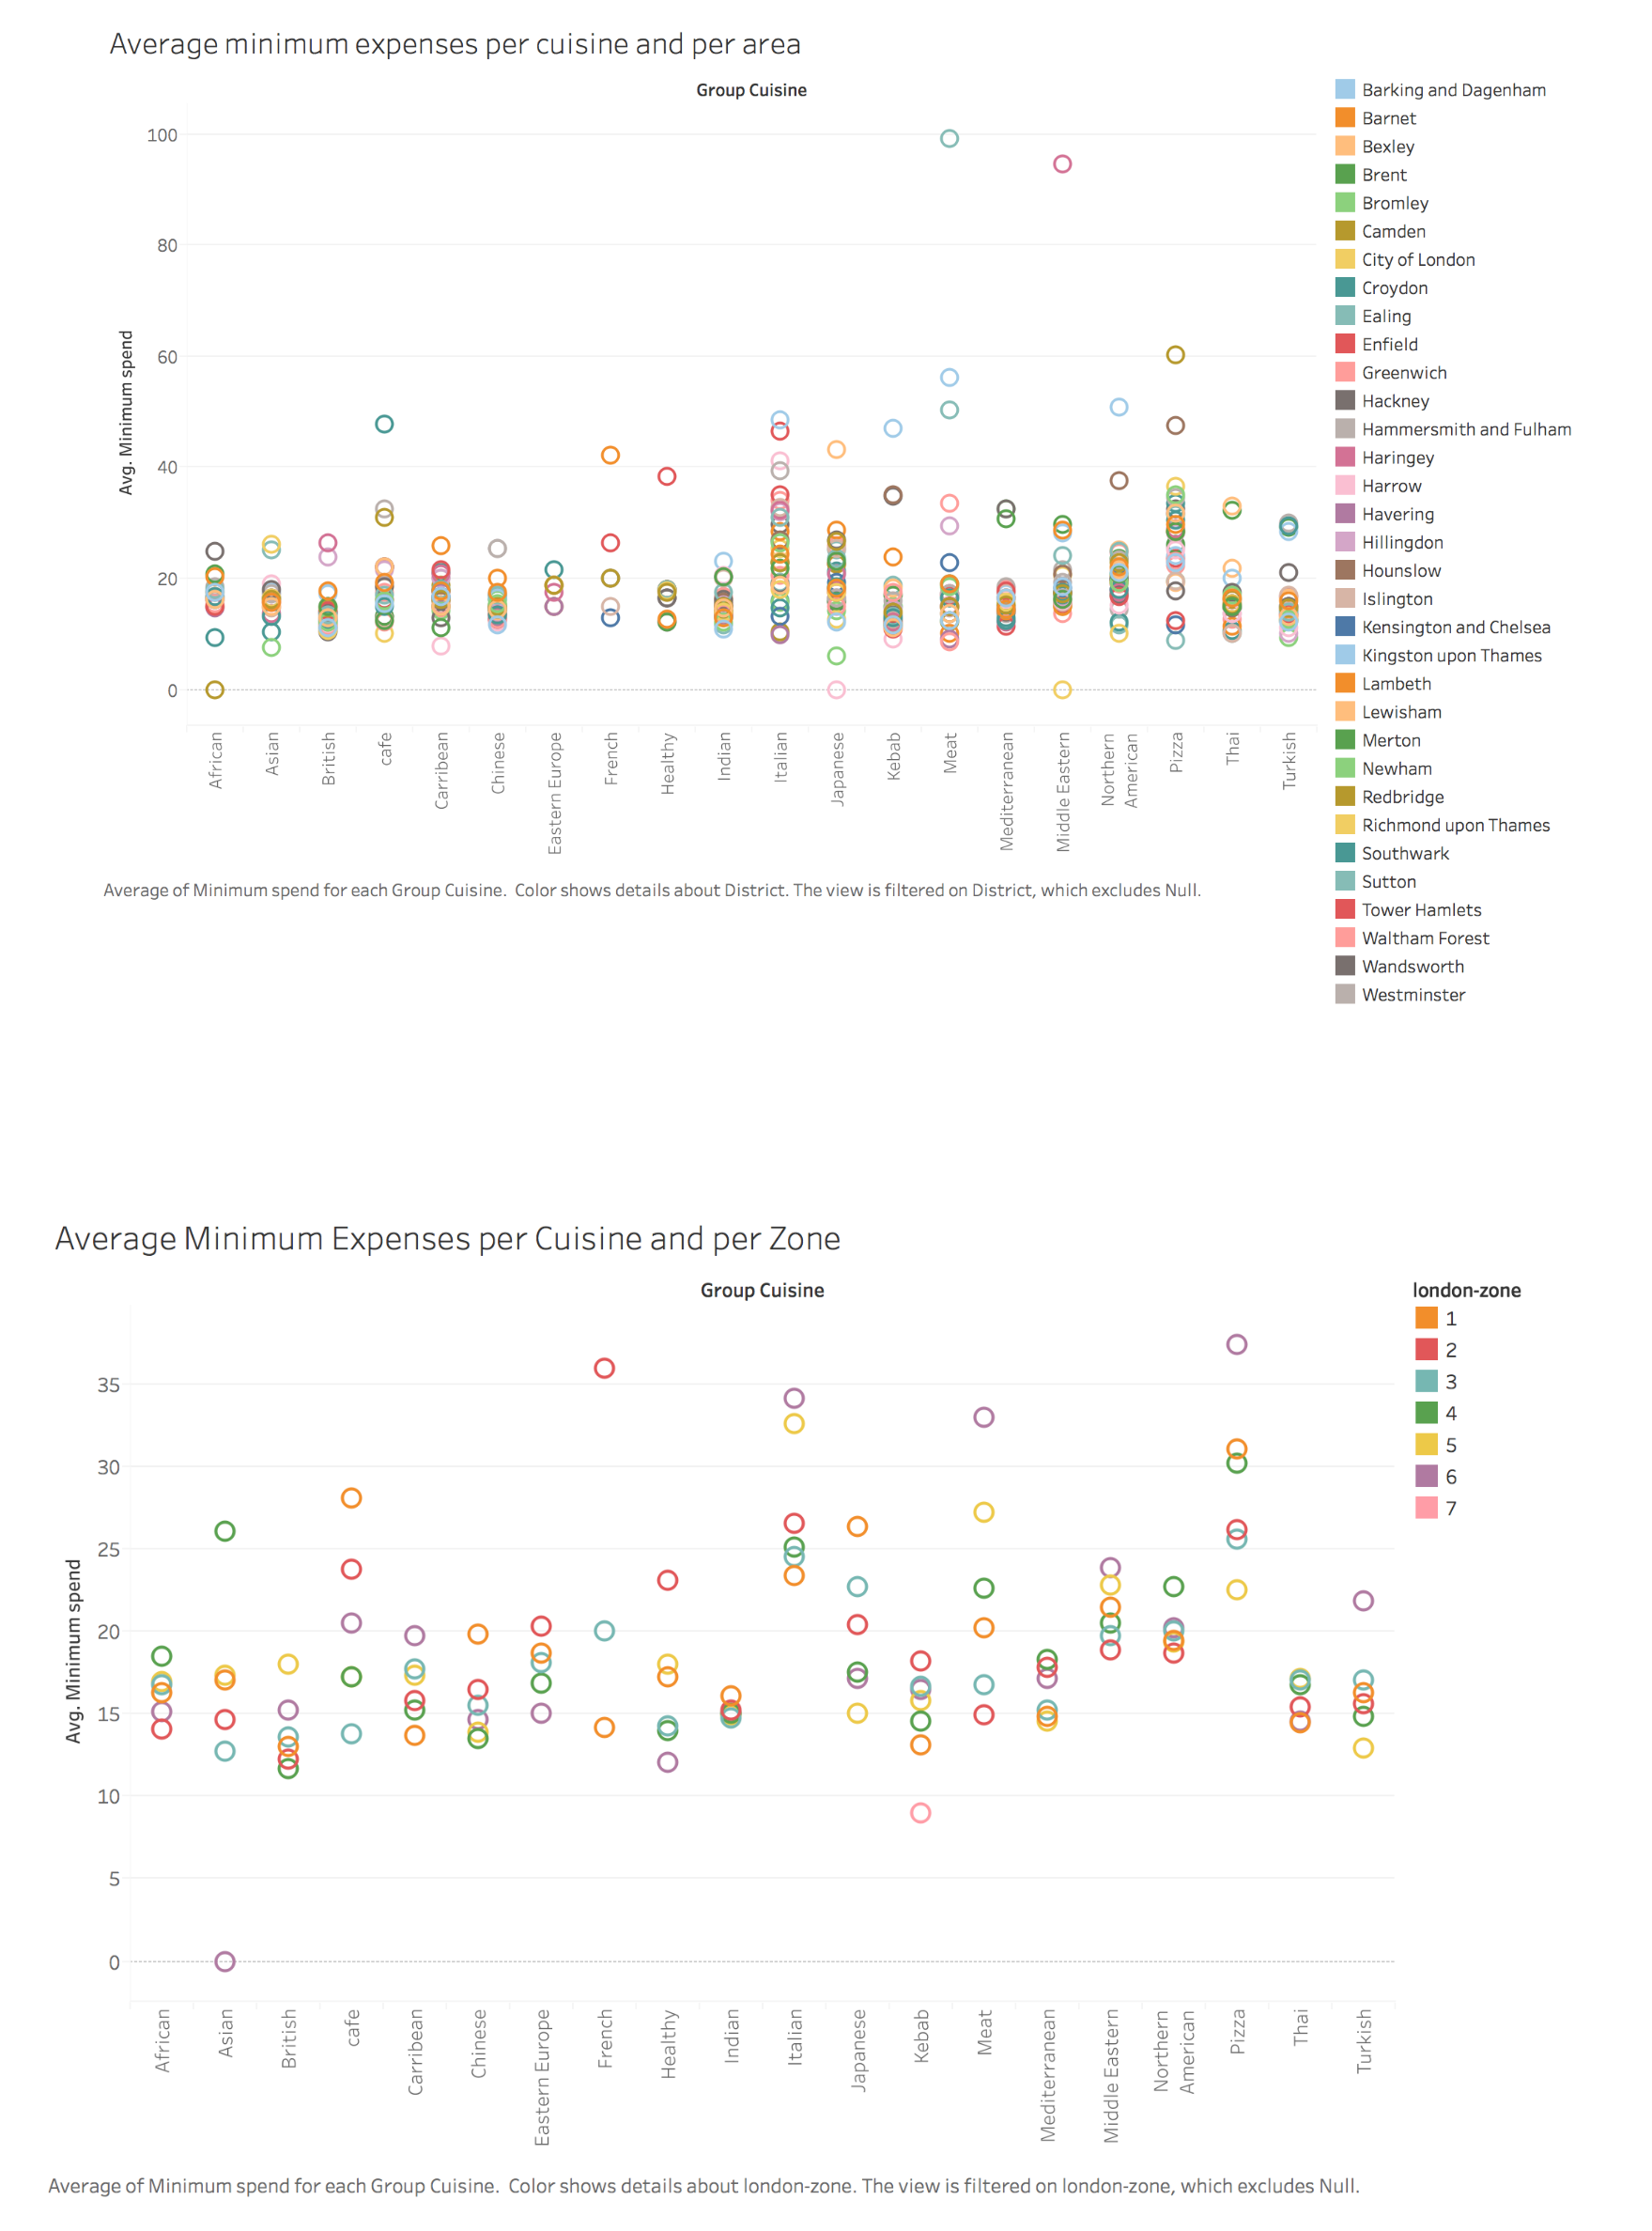

In [31]:
# print tableau plot minimum expenses average per cuisine per area
img1=plt.imread("cuisine_per_area_just-eat.png")
plt.figure(figsize=(70,30))

ax1=plt.subplot(211)
ax1.axis("off")
ax1.imshow(img1)


img2=plt.imread("cuisine-per-zone_just-eat.png")
ax2=plt.subplot(212)
ax2.axis("off")
ax2.imshow(img2)

plt.show()



The above graph clearly shows the minimum expenses per area for a determined cuisine can differ up to 20 pounds. 

Also, looking at a zone level the average show consequent difference according to how central is the restaurant (like for the cafe or French) even though some for some type of cuisine, it does not respect the hierarchy.

## Summary

We unfortunately have only data about restaurants proposing take-away in London. I am also assuming that I have an almost exhaustive data about take away in London.
Nevertheless, as it gathering more than 7000 restaurants, I will be able to use this dataset to fit our model so that later on, I can apply it to other type of restaurants. However, I will choose the data which are more the most complete (Tripadvisor, Zomato)  

In addition to getting restaurant information from sources (Zomato,Tripadvisor) we now need to assess the impact of the surrounding area for each restaurant.
That's why a next notebook is reserved to the study of some demographic and financial data in London district.

__Next steps:__

- Getting more information about restaurant , likely via Zomato.co.uk, Tripadvisor
- Studying financial and demographic data to then link it to the location of each restaurant.
- Apply the principal components analysis on the Demographic&Financial dataset in order to highlight some cluster of areas.
- Analysis the location and cuisine of restaurant in function of all demographic and financial data.
- Categorise the well functioning of a restaurant
- Fit a model on my dataset 

In [40]:
df.to_csv("just-eat_clean.csv", encoding="UTF-8")